# Solving a Helmholtz wave problem

$$
- \nabla u - k^2 u = 0 \quad \mathrm{in} \space \Omega \\
u = g \quad \mathrm{on}\space\mathrm{the}\space\mathrm{boundary}\space\mathrm{of}\space\Omega,
$$
where $\Omega = [0, 1]^2$ is a unit square.

Use $k = 5$ and $g(x, y) = $
$$
sin(4y) \quad \mathrm{if}\space\mathrm{x} = 0, \\
sin(3x) \quad \mathrm{if}\space\mathrm{y} = 0, \\
sin(3+4y) \quad \mathrm{if}\space\mathrm{x} =1, \\ 
sin(3x+4) \quad \mathrm{if}\space\mathrm{y} = 1.
$$
The finite element method is a method that can approximately solve problems like this by splitting the square $\Omega$ into a mesh of $N \times N$ squares and writing the problem as a matvec problem $A\bf{x} = \bf{b}$

In [1]:
# preamble
import numpy as np
import pyamg
from matplotlib import pyplot as plt
import scipy.sparse as sps
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cgs
from scipy.sparse.linalg import cg
import time
from timeit import timeit
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.linalg import spsolve
from matplotlib import cm

# Part 1: Constructing the matrix A

**Notes:**

On any given row, there are $m = (N-1)^2$ values and likewise for any given column. Hence there are $2m - 1$ values associated with a point $p_i$. Most of these values will be zero for large N.

For $p_i$, the non-zero matrix elements will be the elements $A_{ij}$ where 
$$
j = i-N, i-N+1, i-N+2, i-1, i, i+1, i+N-2, i+N-1, i+N
$$

But the diagonal symmetry of the matrix means that we only need to consider 5 of the entries to construct the it. These are $A_{ij}$ where 

$$
j = i, i+1, i+N-2, i+N-1, i+N
$$

For $j = i+N-2, i+N$ the points are diagonally adjacent and for 
$j = i+N-1, i+1$ the points are horizontally or vertically adjacent. It turns out the matrix $A$ has a banded structure that looks something like:
$$
A =
\begin{pmatrix}
a_{11} & a_{12} & 0 & a_{14} & 0 & 0 & 0 \\
. & a_{22} & a_{23} & a_{24} & a_{25} & 0 & 0 \\
0 & . & ... & 0 & 0 & a_{36} & 0 \\
. & . & 0 & ... & 0 & a_{46} & a_{47} \\
0 & . & . & 0 & . & . & 0 \\
0 & 0 & . & . & . & a_{66} & . \\
0 & 0 & 0 & . & 0 & . & a_{77} 
\end{pmatrix}
$$

where each non-zero diagonal can be efficiently stored as
$$
A' =
\begin{pmatrix}
a_{11} & a_{22} & a_{33} & ... \\
a_{12} & a_{23} & a_{34} & ... \\
a_{14} & a_{25} & a_{36} & ... \\
\end{pmatrix}
$$


With the diagonals stored in this form, it is easy to convert the matrix into any sparse scipy format by using scipy.sparse.diags.

In [2]:
def g(x,y):
    '''Compute the values at the boundaries of the grid'''
    if type(x) != np.ndarray:
        if x==0:
            return np.sin(4*y)
        if x==1:
            return np.sin(3+4*y)
        
    if type(y) != np.ndarray:
        if y==0:
            return np.sin(3*x)
        if y==1:
            return np.sin(3*x + 4)
    
def HelmholtzMatrix(N):
    '''Returns CSR format of the matrix A for N > 3. For N <= 3, a dense matrix is returned instead.'''
    if N%1 != 0 or N < 2:
        raise ValueError('N must be an integer larger than 1')
    h = 1/N
    m = (N-1)**2
    matrix_values = [(24 - 4*(h * k)**2)/9, (-3 - (h * k)**2)/9, 
                     (-12 - (h *k)**2)/36] # values for i=j, horizontally adjacent, diagonally adjacent
        
    # initialising arrays
    main_diag, diag1, diag2, diag3, diag4 = (np.zeros(N-1), np.zeros(N-1), 
                                             np.zeros(N-1), np.zeros(N-1), np.zeros(N-1))
    
    # set values for the first N-1 elements of each diagonal
    main_diag[:] = matrix_values[0] # main diagonal
    diag1[:-1] = matrix_values[1] # horizontally adjacent sites
    diag2[1:] = matrix_values[2] # left diagonally adjacent sites
    diag3[:] = matrix_values[1] # vertically adjacent sites
    diag4[:-1] = matrix_values[2] # right diagonally adjacent sites
    blockMat = np.vstack((diag4, diag3, diag2, diag1, main_diag, diag1, diag2, diag3, diag4)) 
    offsets = [-N, -N+1, -N+2, -1, 0, 1, N-2, N-1, N] 
    
    diagonals = [] # now make the full diagonals
    nrepeats = m/(N-1)
    for d in range(len(offsets)):
        fulldiagonal = np.ravel([blockMat[d, :],]*int(nrepeats))
        fulldiagonal = fulldiagonal[:(m - abs(offsets[d]))]
        diagonals.append(fulldiagonal)
        
    if N < 4:
        A_dense = np.zeros((m, m))
        for d in range(len(offsets)):
            if len(diagonals[d]) == 0:
                continue
            A_dense += np.diag(diagonals[d], k=offsets[d])
        print('WARNING: Cannot construct CSR matrix for N < 4. Dense matrix returned instead.')
        return A_dense
    A_csr = sps.diags(diagonals, offsets=offsets, format='csr')  # construct the CSR matrix
    return A_csr


def HelmholtzVector(N):
    '''Compute the vector b'''
    h = 1/N
    factors = [(12 + h**2 * k**2)/36, (3 + h**2 * k**2)/9]
    vector = np.zeros((N-1)**2)
    c = np.arange(2*h, 1-h, h) # from 2h up to and including 1-2h

    for j in range(len(c)): # compute the values corresponding to the sides and interior of the grid
        vector[(N-1) + j*(N-1)] = factors[0] * (g(0, c[j]+h) + g(0, c[j]-h)) + factors[1] * g(0, c[j]) # left
        vector[2*N-3 + j*(N-1)] = factors[0] * (g(1, c[j]+h) + g(1, c[j]-h)) + factors[1] * g(1, c[j]) # right 
        vector[j+1] = factors[0] * (g(c[j]+h, 0) + g(c[j]-h, 0)) + factors[1] * g(c[j], 0) # bottom
        vector[N*(N-3)+3 + j] = factors[0] * (g(c[j]+h, 1) + g(c[j]-h, 1)) + factors[1] * g(c[j], 1) # top
        
    # values corresponding to the corner of the grid
    vector[0] = factors[0]*(g(0,0) + g(2*h, 0) + g(0, 2*h)) + factors[1]*(g(h,0) + g(0,h)) # bottom left
    vector[N-2] = factors[0]*(g(1,0) + g(1,2*h) + g(1-2*h,0)) + factors[1]*(g(1-h,0) + g(1,h)) # bottom right
    vector[(N-1)**2 - N+1] = factors[0]*(g(0,1) + g(2*h,1) + g(0,1-2*h)) + factors[1]*(g(h,1) + g(0,1-h)) # top left
    vector[(N-1)**2 - 1] = factors[0]*(g(1,1) + g(1-2*h,1) + g(1, 1-2*h)) + factors[1]*(g(1-h,1) + g(1,1-h)) # top right
    return vector

def Helmholtz_Ab(N):
    '''Returns A as a CSR matrix and b as a 1d numpy array'''
    return HelmholtzMatrix(N), HelmholtzVector(N)


Time taken to compute A and b for N=10: 0.002588987350463867


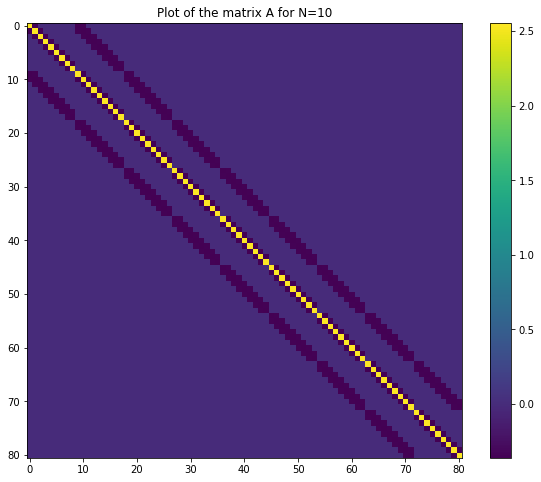

In [3]:
# plotting 
k = 5
N = 10
t = time.time()
A, b = Helmholtz_Ab(N)
t = time.time() - t
print(f'Time taken to compute A and b for N={N}:', t)
plt.figure(figsize=(10,8))
plt.title(f'Plot of the matrix A for N={N}')
plt.imshow(A.todense())
plt.colorbar();

# Part 2: solving the system

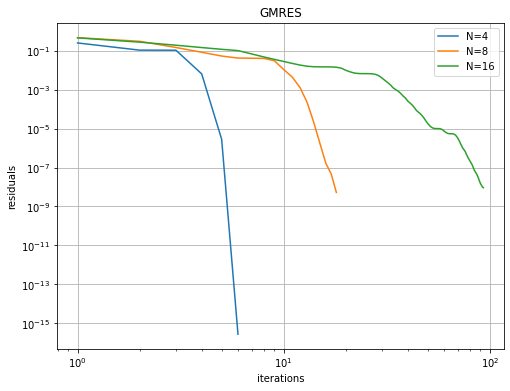

In [4]:
# solve for small N with GMRES
N = [4, 8, 16]
callback = lambda res: residuals.append(res)
solns = []
plt.figure(figsize=(8,6))
for n in N:
    A, b = Helmholtz_Ab(n)
    residuals = []
    x, exitcode = gmres(A, b, callback=callback, callback_type = 'pr_norm', tol=1e-08)
    solns.append(x)
    plt.plot(1 + np.arange(len(residuals)), residuals, label=f'N={n}')
plt.yscale("log")
plt.xscale("log")
plt.ylabel('residuals')
plt.grid(True)
plt.legend(loc='best')
plt.xlabel('iterations')
plt.title('GMRES')
plt.show()

In [5]:
def get_u(N, u_interior):
    '''Returns the solution vector u as an (N,N) matrix'''
    ticks = np.linspace(0,1,N+1)
    u = u_interior.reshape((N-1, N-1), order='F')
    u = np.pad(u, 1)
    # compute boundary values
    u[0,:] = g(0,ticks) # left
    u[-1,:] = g(1,ticks) # right
    u[:,0] = g(ticks,0) # bottom
    u[:,-1] = g(ticks,1) # top
    return u

def plot_u(N, u):
    '''Creates 3d plot of the solution'''
    ticks = np.linspace(0,1,N+1)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.set_title(f'Solution for N = {N}')
    X, Y = np.meshgrid(ticks, ticks,indexing='xy')
    surf = ax.plot_surface(X, Y, u, antialiased=False, cmap=cm.coolwarm)
    plt.show()

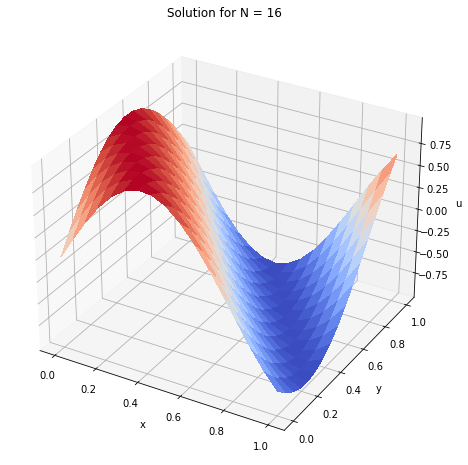

In [6]:
# plot solution
i = 2
n = N[i]
u_interior = solns[i]
u = get_u(n, u_interior)
plot_u(n, u)

# Part 3: comparing solvers and preconditioners

Direct solvers / LU decompositions:
- scipy.sparse.spsolve (uses UMFPACK as default if installed, otherwise uses superLU)
- petsc4py LU solver

Iterative solvers:
- scipy.sparse.cg (requires Hermitian positive definite matrix)
- scipy.sparse.gmres (struggles to converge when eigenvalues are centred on 0)
- scipy.sparse.bicg (bi-conjugate CG)
- scipy.sparse.cgs (conjugate gradient squared)
- scipy.sparse.lgmres

Multigrid solvers:
- PyAMG (algebraic multigrid solver)

Preconditioners:
- scipy.sparse.spilu (incomplete LU decomposition)
- AMG solvers
- SPAI (sparse approximate inverse)
- petsc4py has several preconditioners

**I will use scipy.spsolve (i.e. UMFPACK), scipy.cg, scipy.cgs, scipy.gmres, pyamg.smoothed_aggregation_solver  as my solvers.**

In [7]:
def precon_amg(A):
    '''
    Returns:
    - AMG preconditioner
    - time taken to construct preconditioner
    '''
    t1 = time.time() # make preconditioner
    ml = pyamg.smoothed_aggregation_solver(A)      # AMG solver
    M = ml.aspreconditioner(cycle='V')             # preconditioner
    t2 = time.time() - t1
    return M, t2

def precon_spilu(A):
    '''
    Input A must be in CSC format
    Returns:
    - SPILU preconditioner
    - time taken to construct preconditioner
    '''
    t1 = time.time()
    Ainv = sps.linalg.spilu(A)
    M = sps.linalg.LinearOperator(A.shape, Ainv.solve)
    t2 = time.time() - t1
    return M, t2

def precon_svds(A):
    '''
    Returns:
    - inverse singular value decomposition (SVD) preconditioner
    - time taken to construct preconditioner
    '''
    t1 = time.time()
    u, s, v = sps.linalg.svds(A, tol=1) 
    M = np.dot(v.transpose(), u.transpose())/np.mean(s) # estimate inverse using singular value decompositions
    t2 = time.time()- t1
    return M, t2

def use_gmres(A, b, tol, maxiter, M=None):
    '''
    Use sps.gmres solver.
    Returns:
    - solution vector x
    - time taken
    - residuals
    - niters
    '''
    callback = lambda res: residuals.append(res)
    residuals = []
    t1 = time.time()
    x, _ = gmres(A, b, M=M, callback=callback, callback_type = 'pr_norm', tol=tol, maxiter=maxiter)
    t2 = time.time() - t1
    niters = len(residuals)
    return x, t2, residuals, niters

def use_cgs(A, b, tol, maxiter, M=None):
    '''
    Use sps.cgs solver.
    Returns:
    - solution vector x
    - time taken
    - residuals
    - niters
    '''
    callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))
    residuals = []
    t1 = time.time()
    x, _ = cgs(A, b, M=M, callback=callback, tol=tol, maxiter=maxiter)
    t2 = time.time() - t1
    niters = len(residuals)
    return x, t2, residuals, niters

def use_cg(A, b, tol, maxiter, M=None):
    '''
    Use sps.cg solver.
    Returns:
    - solution vector x
    - time taken
    - residuals
    - niters
    '''
    callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))
    residuals = []
    t1 = time.time()
    x, _ = cg(A, b, M=M, callback=callback, tol=tol, maxiter=maxiter)
    t2 = time.time() - t1
    niters = len(residuals)
    return x, t2, residuals, niters

def use_pyamg(A,b, tol, maxiter):
    '''
    Use pyamg.smoothed_aggregration_solver.
    Returns:
    - solution vector x
    - time taken
    - residuals
    - niters
    '''
    residuals = []
    t1 = time.time() # include time taken to construct solver
    ml = pyamg.smoothed_aggregation_solver(A) # AMG solver
    x = ml.solve(b, tol=tol, residuals=residuals, maxiter=maxiter)
    t2 = time.time() - t1
    niters = len(residuals)
    return x, t2, residuals, niters

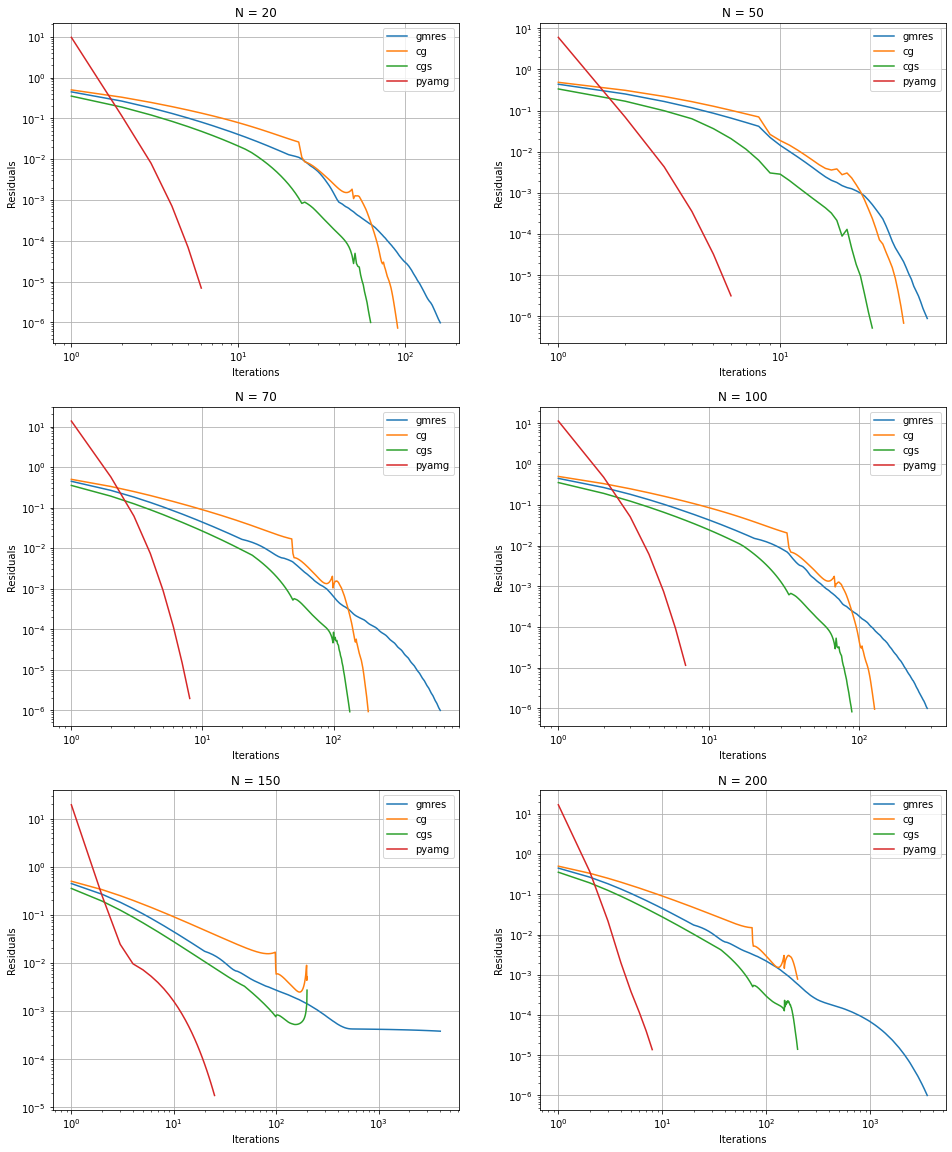

In [34]:
# set variables
N = [20, 50, 70, 100, 150, 200]
tol = 1e-06
maxiter = 200

t_gmres = []
t_cg = []
t_cgs = []
t_amg = []
t_spsolve = []

niters_gmres = []
niters_cg = []
niters_cgs = []
niters_amg = []
niters_spsolve = []

# plot residuals, compute times and number of residuals
fig, axs = plt.subplots(3, 2, figsize=(16,20))
k=-1 # use this to set subplot positions
for n in N:
    k+=1
    if k%2==0:
        pos = int(k/2), 1 # right subplot
    else:
        pos = int(k/2), 0 # left subplot
    A, b = Helmholtz_Ab(n)
    # gmres
    _, t, residuals, niters = use_gmres(A, b, tol=tol, maxiter=maxiter)
    t_gmres.append(t)
    niters_gmres.append(niters)
    axs[pos].plot(1 + np.arange(niters), residuals, label='gmres')

    # cg
    _, t, residuals, niters = use_cg(A,b, tol=tol, maxiter=maxiter)
    t_cg.append(t)
    niters_cg.append(niters)
    axs[pos].plot(1 + np.arange(niters), residuals, label='cg')

    # cgs
    _, t, residuals, niters = use_cgs(A,b, tol=tol, maxiter=maxiter)
    t_cgs.append(t)
    niters_cgs.append(niters)
    axs[pos].plot(1 + np.arange(niters), residuals, label='cgs')

    # pyamg
    _, t, residuals, niters = use_pyamg(A,b, tol=tol, maxiter=maxiter)
    t_amg.append(t)
    niters_amg.append(len(residuals))
    axs[pos].plot(1 + np.arange(niters), residuals, label='pyamg')

    # scipy spsolve
    t = time.time()
    x = spsolve(A, b, use_umfpack=True)
    t_spsolve.append(time.time() - t)

# fig.suptitle('Residuals at each iteration')
i = -1
for ax in axs.flat:
    i+=1
    ax.set_title(f'N = {N[i]}')
    ax.set(xlabel='Iterations', ylabel='Residuals')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend();


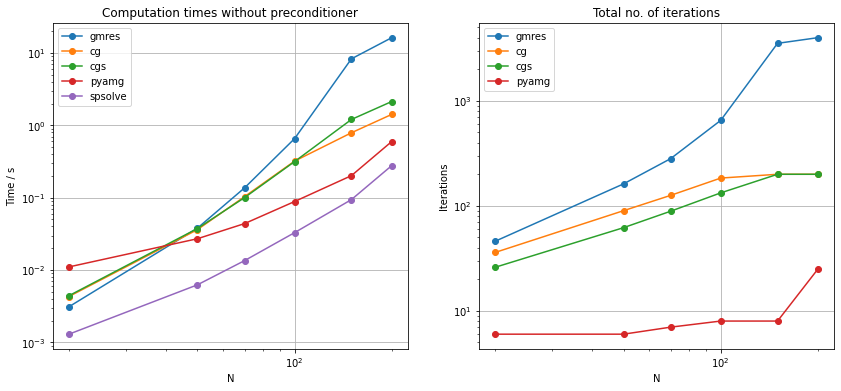

In [35]:
# plot times
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(N, t_gmres, '-o', label='gmres')
ax1.plot(N, t_cg, '-o', label='cg')
ax1.plot(N, t_cgs, '-o', label='cgs')
ax1.plot(N, t_amg, '-o', label='pyamg')
ax1.plot(N, t_spsolve, '-o', label='spsolve')
ax1.set_xlabel('N')
ax1.set_ylabel('Time / s')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend()
ax1.set_title('Computation times without preconditioner');

# plot niters
ax2.plot(N, niters_gmres, '-o', label='gmres')
ax2.plot(N, niters_cg, '-o', label='cg')
ax2.plot(N, niters_cgs, '-o', label='cgs')
ax2.plot(N, niters_amg, '-o', label='pyamg')
ax2.set_xlabel('N')
ax2.set_ylabel('Iterations')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(True)
ax2.legend()
ax2.set_title('Total no. of iterations');

**Comments on the solvers:**

The best iterative solver for small-medium $N$ appears to be CGS, with CG having very similar performance. The main distinction between CGS and CG is that CGS takes fewer iterations to converge and appears to have smoother behaviour (see residuals plot). The AMG solver is very unstable - often it does not converge to a solution at all. GMRES is the slowest of the iterative solvers used; this could be because of the eigenvalue distribution of the matrix $A$. I will investigate the effect of pre-conditioners on the GMRES and CGS solvers in the next part.

The preconditioners I will use:
- scipy.sparse.spilu
- pyamg.smoothed_aggregation_solver
- I will create my own preconditioner by using singular value decompositions (SVDs) of A to approximate its inverse. 

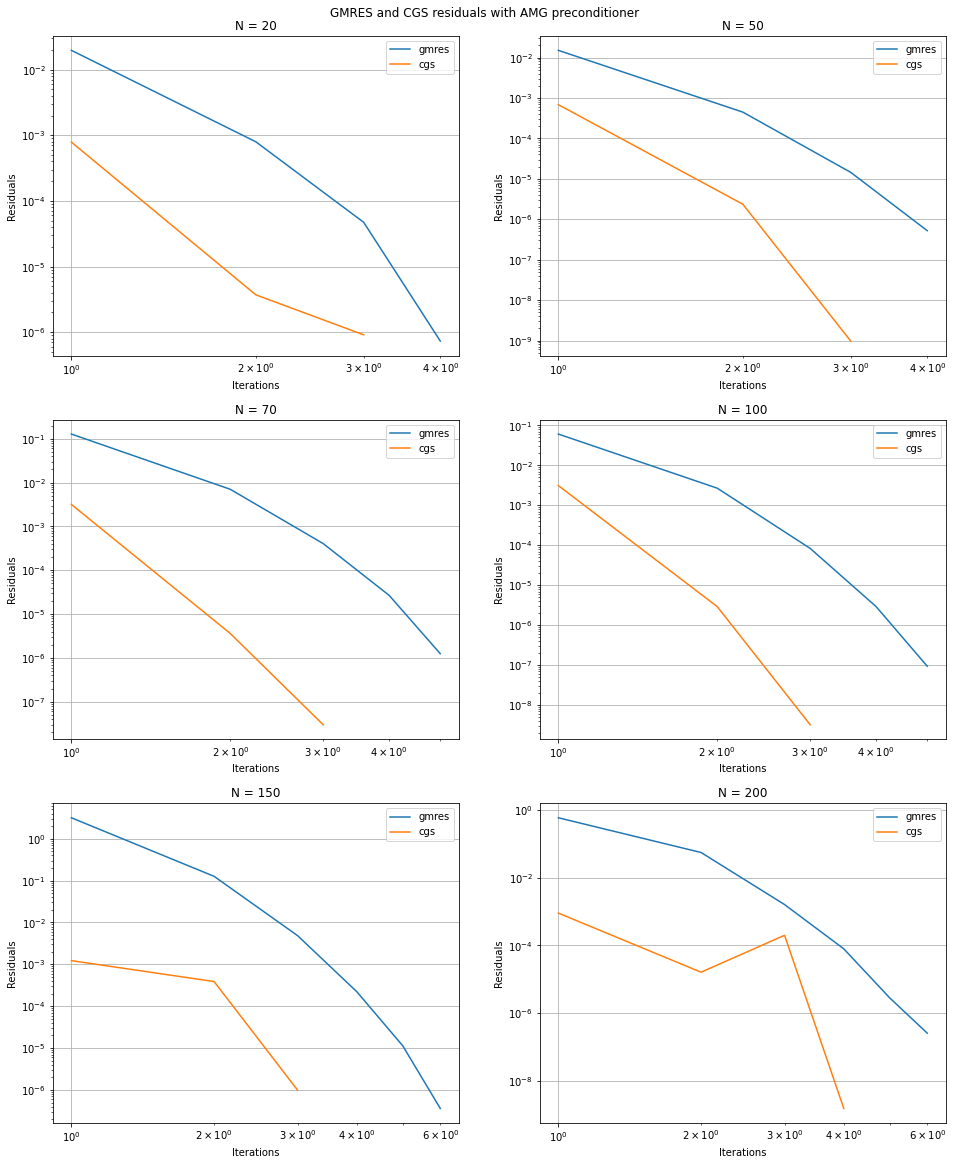

In [10]:
####################### USING AMG PRECONDITIONER #######################
t_gmres = []
t_cgs = []
niters_gmres = []
niters_cgs = []

# plot residuals, compute times and number of residuals with AMG preconditioner
t_pc_amg = [] # store time taken to compute preconditioner
fig, axs = plt.subplots(3, 2, figsize=(16,20))
k=-1 # use this to set subplot positions
for n in N:
    k+=1
    if k%2==0:
        pos = int(k/2), 1 # right subplot
    else:
        pos = int(k/2), 0 # left subplot
    A, b = Helmholtz_Ab(n)
    M, t = precon_amg(A) # construct preconditioner
    t_pc_amg.append(t)
    
    # gmres
    _, t, residuals, niters = use_gmres(A, b, tol=tol, maxiter=maxiter/20, M=M) # divide maxiter by restarts=20
    t_gmres.append(t)
    niters_gmres.append(niters)
    axs[pos].plot(1 + np.arange(niters), residuals, label='gmres')

    # cgs
    _, t, residuals, niters = use_cgs(A, b, tol=tol, maxiter=maxiter, M=M)
    t_cgs.append(t)
    niters_cgs.append(niters)
    axs[pos].plot(1 + np.arange(niters), residuals, label='cgs')
    
times_amg = {"gmres": t_gmres, "cgs": t_cgs}
niters_amg = {"gmres": niters_gmres, "cgs": niters_cgs}

fig.suptitle('GMRES and CGS residuals with AMG preconditioner', y=0.9)
i = -1
for ax in axs.flat:
    i+=1
    ax.set_title(f'N = {N[i]}')
    ax.set(xlabel='Iterations', ylabel='Residuals')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend();

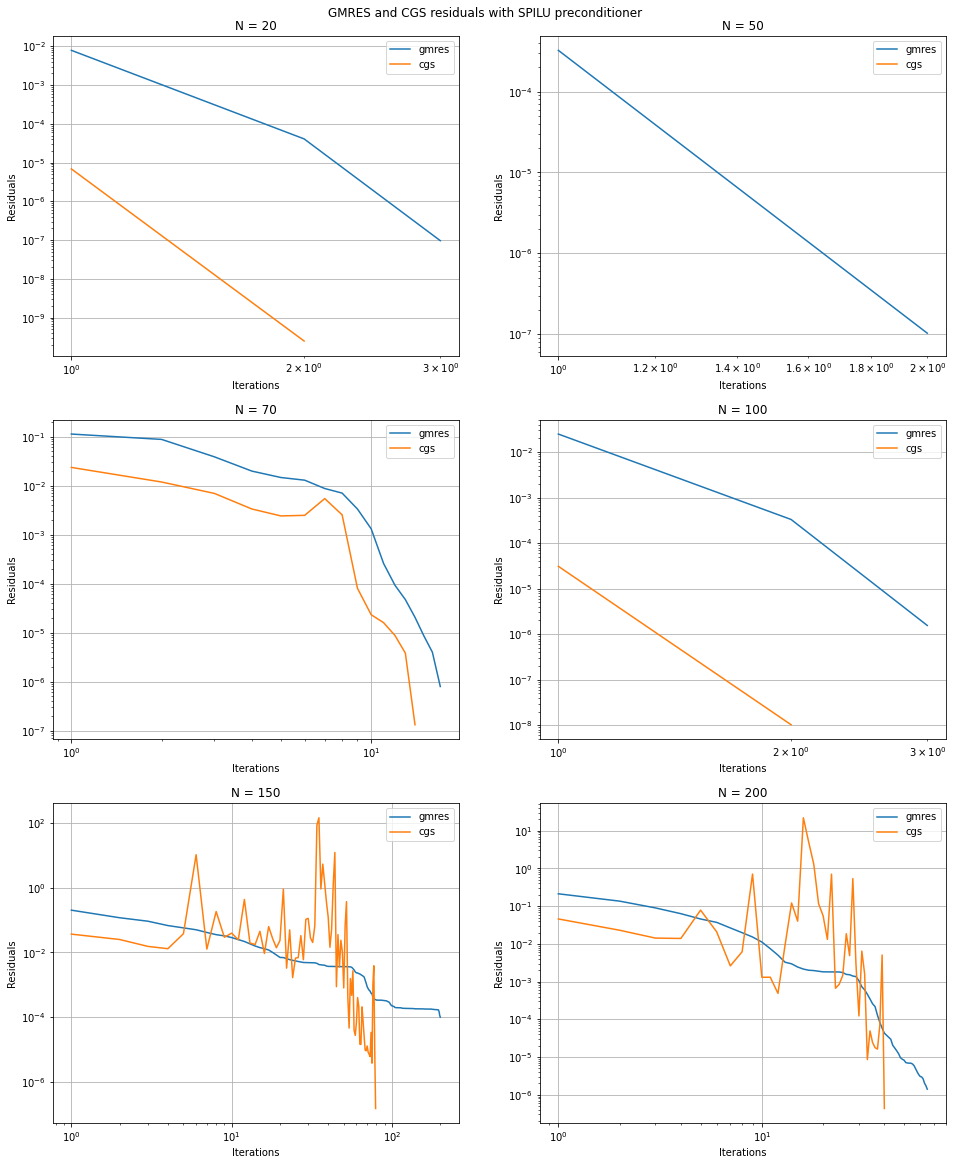

In [11]:
####################### USING SPILU PRECONDITIONER #######################
t_gmres = []
t_cgs = []
niters_gmres = []
niters_cgs = []

# plot residuals, compute times and number of residuals with SPILU preconditioner
t_pc_spilu = [] # store time taken to compute preconditioner
fig, axs = plt.subplots(3, 2, figsize=(16,20))
k=-1 # use this to set subplot positions
for n in N:
    k+=1
    if k%2==0:
        pos = int(k/2), 1 # right subplot
    else:
        pos = int(k/2), 0 # left subplot
    Acsr, b = Helmholtz_Ab(n)
    A = sps.csc_matrix(Acsr) # spilu requires csc format
    M, t = precon_spilu(A) # make preconditioner
    t_pc_spilu.append(t)
    
    # gmres
    _, t, residuals, niters = use_gmres(A, b, tol=tol, maxiter=maxiter/20, M=M) # divide maxiter by restarts=20
    t_gmres.append(t)
    niters_gmres.append(niters)
    axs[pos].plot(1 + np.arange(niters), residuals, label='gmres')

    # cgs
    _, t, residuals, niters = use_cgs(A, b, tol=tol, maxiter=maxiter, M=M)
    t_cgs.append(t)
    niters_cgs.append(niters)
    axs[pos].plot(1 + np.arange(niters), residuals, label='cgs')
    
times_spilu = {"gmres": t_gmres, "cgs": t_cgs}
niters_spilu = {"gmres": niters_gmres, "cgs": niters_cgs}

fig.suptitle('GMRES and CGS residuals with SPILU preconditioner', y=0.9)
i = -1
for ax in axs.flat:
    i+=1
    ax.set_title(f'N = {N[i]}')
    ax.set(xlabel='Iterations', ylabel='Residuals')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend();

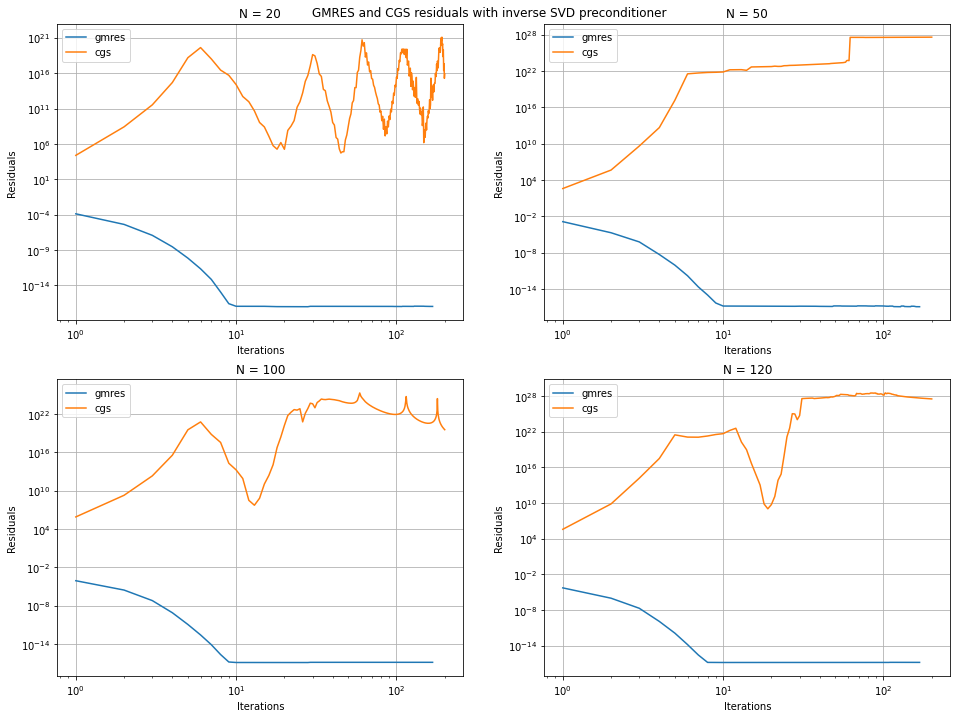

In [12]:
####################### USING INVERSE SVD PRECONDITIONER #######################
N_svds = [20, 50, 100, 120]
t_gmres = []
t_cgs = []
niters_gmres = []
niters_cgs = []

t_pc_svds = [] # store time taken to compute preconditioner
fig, axs = plt.subplots(2, 2, figsize=(16,12))
k=-1 # use this to set subplot positions
for n in N_svds:
    k+=1
    if k%2==0:
        pos = int(k/2), 1 # right subplot
    else:
        pos = int(k/2), 0 # left subplot
    A, b = Helmholtz_Ab(n)
    M, t = precon_svds(A) # estimate inverse using singular value decompositions
    t_pc_svds.append(t)
    
    # gmres
    _, t, residuals, niters = use_gmres(A, b, tol=tol, maxiter=maxiter/20, M=M) # divide maxiter by restarts=20
    t_gmres.append(t)
    niters_gmres.append(niters)
    axs[pos].plot(1 + np.arange(niters), residuals, label='gmres')

    # cgs
    _, t, residuals, niters = use_cgs(A, b, tol=tol, maxiter=maxiter, M=M)
    t_cgs.append(t)
    niters_cgs.append(niters)
    axs[pos].plot(1 + np.arange(niters), residuals, label='cgs')
    
times_svds = {"gmres": t_gmres, "cgs": t_cgs}
niters_svds = {"gmres": niters_gmres, "cgs": niters_cgs}

fig.suptitle('GMRES and CGS residuals with inverse SVD preconditioner', y=0.9)
i = -1
for ax in axs.flat:
    i+=1
    ax.set_title(f'N = {N_svds[i]}')
    ax.set(xlabel='Iterations', ylabel='Residuals')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend();

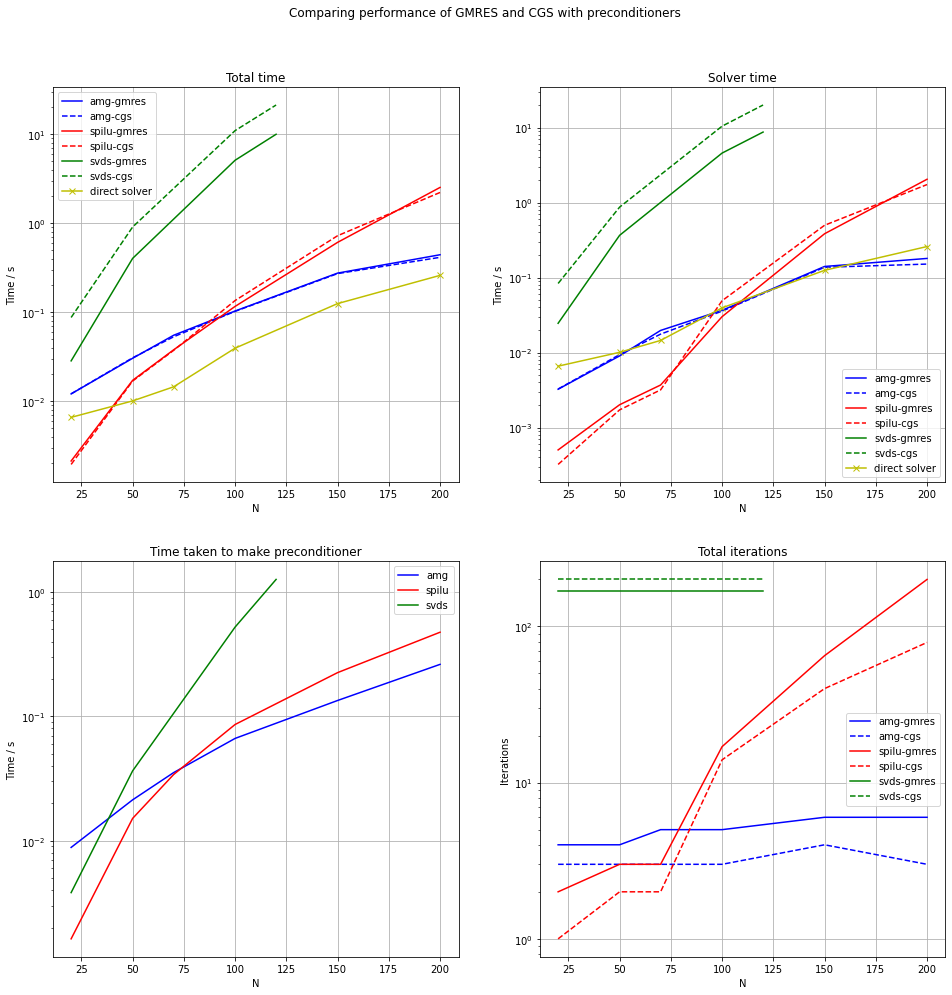

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16,16))

# plot total time to solve and compute preconditioner
pos = 0,0
axs[pos].plot(N, np.array(times_amg["gmres"]) + np.array(t_pc_amg), 'b-', label='amg-gmres')
axs[pos].plot(N, np.array(times_amg["cgs"]) + np.array(t_pc_amg), 'b--', label='amg-cgs')
axs[pos].plot(N, np.array(times_spilu["gmres"]) + np.array(t_pc_spilu), 'r-', label='spilu-gmres')
axs[pos].plot(N, np.array(times_spilu["cgs"]) + np.array(t_pc_spilu), 'r--', label='spilu-cgs')
axs[pos].plot(N_svds, np.array(times_svds["gmres"]) + np.array(t_pc_svds), 'g-', label='svds-gmres')
axs[pos].plot(N_svds, np.array(times_svds["cgs"]) + np.array(t_pc_svds), 'g--', label='svds-cgs')
axs[pos].plot(N, t_spsolve, 'y-x', label='direct solver') # compare with sparse direct solver

# plot solving time
pos = 0,1
axs[pos].plot(N, times_amg["gmres"], 'b-', label='amg-gmres')
axs[pos].plot(N, times_amg["cgs"], 'b--', label='amg-cgs')
axs[pos].plot(N, times_spilu["gmres"], 'r-', label='spilu-gmres')
axs[pos].plot(N, times_spilu["cgs"], 'r--', label='spilu-cgs')
axs[pos].plot(N_svds, times_svds["gmres"], 'g-', label='svds-gmres')
axs[pos].plot(N_svds, times_svds["cgs"], 'g--', label='svds-cgs')
axs[pos].plot(N, t_spsolve, 'y-x', label='direct solver') # compare with sparse direct solver

# plot times taken to compute preconditioners
pos = 1,0
axs[pos].plot(N, t_pc_amg, 'b-', label='amg')
axs[pos].plot(N, t_pc_spilu, 'r-', label='spilu')
axs[pos].plot(N_svds, t_pc_svds, 'g-', label='svds')

# plot iterations
pos = 1, 1
axs[pos].plot(N, niters_amg["gmres"], 'b-', label='amg-gmres')
axs[pos].plot(N, niters_amg["cgs"], 'b--', label='amg-cgs')
axs[pos].plot(N, niters_spilu["gmres"], 'r-', label='spilu-gmres')
axs[pos].plot(N, niters_spilu["cgs"], 'r--', label='spilu-cgs')
axs[pos].plot(N_svds, niters_svds["gmres"], 'g-', label='svds-gmres')
axs[pos].plot(N_svds, niters_svds["cgs"], 'g--', label='svds-cgs')

titles = ['Total time', 'Solver time', 'Time taken to make preconditioner', 'Total iterations']
ylabels = ['Time / s', 'Time / s', 'Time / s', 'Iterations']
fig.suptitle('Comparing performance of GMRES and CGS with preconditioners', y=0.95)
i = -1
for ax in axs.flat:
    i+=1
    ax.set_title(titles[i])
    ax.set(xlabel='N', ylabel=ylabels[i])
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend();

### Choosing a solver:

Based on the previous data, I expect the CGS solver with the AMG preconditioner (let's call this AMG-CGS) is the best solver for this problem as N increases. My justification is: 
- For $N=100$, we see that the sparse direct solver (spsolve) is fastest, with total time taken $\approx 0.05$ seconds, with the second fastest method (AMG-CGS) taking $\approx 0.1$ s. However, spsolve slows down more than AMG-CGS so that for $N=200$, they both take $\approx 0.5$ s. Based on this I expect AMG-CGS to be the fastest method for $N>200$.
- The AMG preconditioner clearly has the best performance out of the ones demonstrated. Both the CGS and GMRES solvers are stable (i.e. the residuals curve is smoothest) with AMG for all the N values tested, and the plot of  time taken to construct the preconditioner has the lowest gradient of the options tried. 
- Based on the previous points, I expect AMG-CGS to be both stable and fast for higher N.

**Comments on the preconditioners:**
- The inverse SVD preconditioner gives the correct solutions with GMRES, but fails with CGS. It also takes too long to compute the preconditioner using this method. 
- SPILU makes both the solvers unstable (the residuals curve is peaking/spiking a lot).

## Part 4: increasing $N$

I will use the CGS solver with an AMG preconditioner

In [28]:
def cgs_amg(N, tol, maxiter, plot_residuals=False):
    '''
    CGS solver with AMG preconditioner.
    Returns: 
    - Solution vector u
    - [Total time to solve and compute preconditioner, time taken to solve, time taken to compute preconditioner]
    - niters
    - cgs exitcode
    '''
    A, b = Helmholtz_Ab(N)
    t = time.time()
    ml = pyamg.smoothed_aggregation_solver(A)      # create pyamg instance
    M = ml.aspreconditioner(cycle='V')             # preconditioner
    t_precon = time.time()- t # preconditioner time
    
    callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))
    residuals = []
    t = time.time()
    u, exitcode = cgs(A, b, M=M, callback=callback, tol=tol, maxiter=maxiter) 
    t_solve = time.time() - t # solve time
    niters = len(residuals)
    if plot_residuals==True:
        plt.figure()
        plt.plot(1 + np.arange(len(residuals)), residuals, '-')
        plt.title(f'CGS residuals with AMG preconditioner for N={N}')
        plt.yscale("log"); plt.xscale("log")
        plt.ylabel('residuals'); plt.xlabel('iterations')
        plt.grid(True)
        plt.show()
    return u, [t_solve+t_precon, t_solve, t_precon], niters, exitcode 

def get_midpoints(N, uh):
    '''Returns midpoints of the interior solution as an array with shape=(N,N)'''
    xmidpoints=np.zeros((N+1,N))
    midpoints = np.zeros((N,N))
    for i in range(N):
        xmidpoints[:,i] = np.mean(uh[:,i:i+2], axis=1) # take mean of pairs of columns
    for i in range(N):
        midpoints[i,:] = np.mean(xmidpoints[i:i+2,:], axis=0) # take mean of pairs of rows
    return midpoints

def get_error(N, uh):
    '''Returns error of approximate solution'''
    h = 1/N
    uh_midpoints = get_midpoints(N,uh)
    ticks = np.linspace(0, 1, N+1) + h/2
    ticks = ticks[:-1]
    mx, my = np.meshgrid(ticks, ticks, indexing='ij')
    u_exact = np.sin(3*mx + 4*my)
    return np.sum(h**2 * np.abs(u_exact - uh_midpoints))

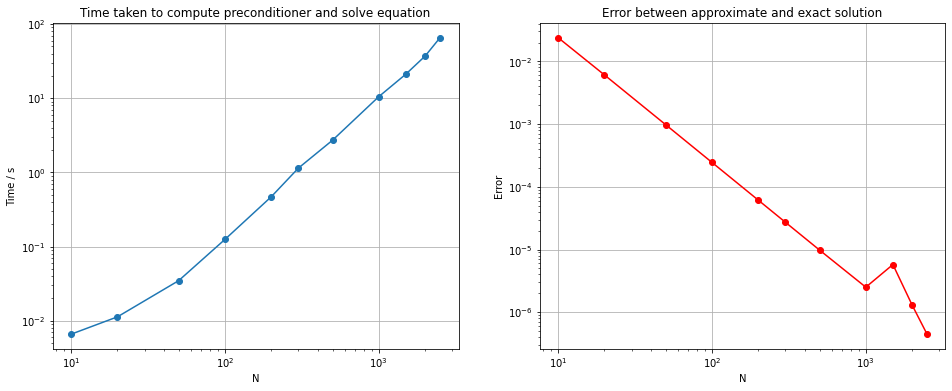

In [29]:
N = [10, 20, 50, 100, 200, 300, 500, 1000, 1500, 2000, 2500]
maxiter = 500
tol = 1e-08
total_times = []
solver_times = []
precon_times = []
errors = []
for n in N:
    u_interior, times, niters, _ = cgs_amg(n, tol=tol, maxiter=maxiter, plot_residuals=False)
    total_times.append(times[0])
    solver_times.append(times[1])
    precon_times.append(times[2])
    uh = get_u(n, u_interior)
    err = get_error(n, uh)
    errors.append(err)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(N, total_times, '-o')
ax1.set_xlabel('N')
ax1.set_ylabel('Time / s')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(True)
ax1.set_title('Time taken to compute preconditioner and solve equation');

ax2.plot(N, errors, 'r-o')
ax2.set_xlabel('N')
ax2.set_ylabel('Error')
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.grid(True)
ax2.set_title('Error between approximate and exact solution');

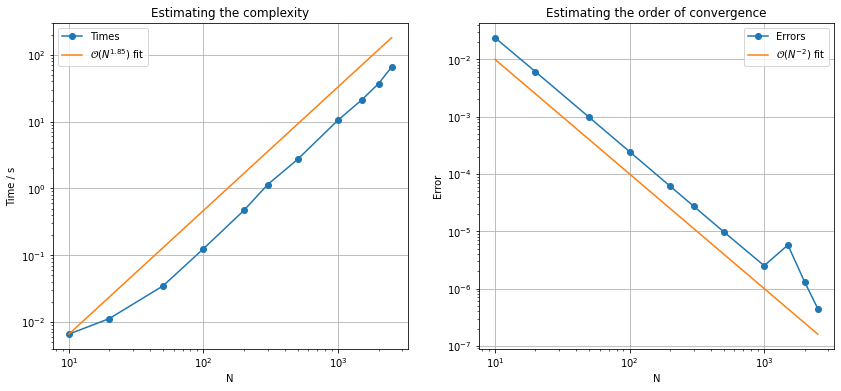

In [30]:
# estimate the complexity and convergence by fitting some polynomials to the plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(N, total_times, '-o', label='Times')
ax1.plot(N, (total_times[0] / 10**1.85) * np.array(N)**1.85, '-', label="$\mathcal{O}(N^{1.85})$ fit")
ax1.set_xlabel('N')
ax1.set_ylabel('Time / s')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(True)
ax1.legend()
ax1.set_title('Estimating the complexity');

ax2.plot(N, errors, '-o', label='Errors')
ax2.plot(N, 1/np.array(N)**2, '-', label="$\mathcal{O}(N^{-2})$ fit")
ax2.set_xlabel('N')
ax2.set_ylabel('Error')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(True)
ax2.legend()
ax2.set_title('Estimating the order of convergence');

### Comments on complexity and order of convergence

Based on the above plots, the complexity is approximately $\mathcal{O}(N^{1.85})$ and the convergence is $\mathcal{O}(N^{-2})$. The complexity and convergence were estimated by fitting a line so that it was parallel to the plotted data, which is generally a good way to avoid overfitting. A more precise measure might be take the gradients of the time and error lines directly. It is also worth noting that there is a bump in the convergence plot at $N=1500$, which might be indicative that the order of convergence will worsen as $N$ increases further. 

## Part 5: can it be parallelised?

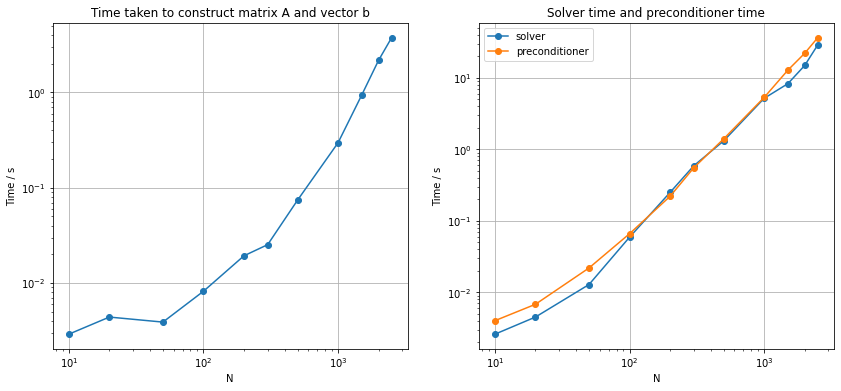

In [31]:
N = [10, 20, 50, 100, 200, 300, 500, 1000, 1500, 2000, 2500]
buildtimes = []
for n in N:
    t1 = time.time()
    _,  _ = Helmholtz_Ab(n)
    t2 = time.time() - t1
    buildtimes.append(t2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(N, buildtimes, '-o')
ax1.set_xlabel('N')
ax1.set_ylabel('Time / s')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(True)
ax1.set_title('Time taken to construct matrix A and vector b');

ax2.plot(N, solver_times, '-o', label='solver')
ax2.plot(N, precon_times, '-o', label='preconditioner')
ax2.set_xlabel('N')
ax2.set_ylabel('Time / s')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(True)
ax2.legend()
ax2.set_title('Solver time and preconditioner time');

**Parallelising the CGS solver:**
Around half of the total computation time is the time taken by the scipy.sparse.linalg.cgs solver. The solver is already highly optimised, but by default scipy is single-threaded, so it would be difficult to implement CPU multithreading with the solver. I would expect a speed-up by a factor of 3 since there are 3 matvec operations that can happen in parallel at each iteration in the CG algorithm (see lecture notes). GPU parallelisation would probably make performance worse because the solver is sequential. GPU parallelisation of the matvec operations within each iteration would probably not give speed-up since matvec operations are already highly optimised.

**Parallelising the AMG preconditioner:**
GPU parallelisation is generally very good for computations on grids. I would expect a speed-up by around a factor equal to the total number of threads. This has the limitation that a huge GPU would be required for large $N$ because the number of threads would scale like $N^2$. I expect that it would be very difficult to implement GPU parallelisation with PyAMG and a custom AMG method would probably be needed. 

**Paralellising the matrix and vector computations:**
The time taken to create the matrix and vector by calling *Helmholtz_Ab( )* is short compared to the total time taken - it is around $2.5 \%$ of the total computation time for $N=1000$. However, GPU parallelisation of *HelmholtzVector( )*  would also be easy to implement and I would expect a speed-up by a nearly a factor of N since the code loops N times. GPU parallelisation of *HelmholtzMatrix( )* would require the code to be written very differently, so is less easy to implement. It should be easy to do CPU parallelisation / multithreading of the *HelmholtzVector( )* and *HelmholtzMatrix( )* functions with Numexpr since I intentionally wrote these functions so that the most of the computation uses slicing. I wouldn't expect either of the functions to have any significant speed-up with CPU multithreading.